# Multilingual Offline Forged  Signature Using Siamese Neural Network and Few-Shot Learning

Contrastive Loss

2-ways 10-shot

In [2]:
!pip install keras

In [3]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf

from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D, Subtract
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import DenseNet121
from keras.applications import ResNet50V2

import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [20]:
# Paths to Datasets
cedar_path = "/content/drive/MyDrive/Multilingual dataset/CEDAR"
bengali_path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali"
hindi_path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi"

# All the images will be converted to the same size before processing
img_h, img_w = 120, 120

# Preprocessing Function
def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    if image is None or len(image) == 0 or image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} is empty or None or has invalid dimensions.")
        return None
    image = cv2.resize(image, (img_h, img_w))
    image = cv2.merge((image, image, image))  # Convert grayscale to RGB
    image = image.astype('float32') / 255.0  # Normalize pixel values
    return image

# Load Data Function
def load_data(path, forged_count, genuine_count):
    dir_list = next(os.walk(path))[1]
    orig_groups, forg_groups = [], []
    for directory in dir_list:
        images = os.listdir(os.path.join(path, directory))
        images.sort()
        images = [os.path.join(path, directory, x) for x in images]
        forg_groups.append(images[:forged_count])
        orig_groups.append(images[forged_count:forged_count + genuine_count])
    return orig_groups, forg_groups

# Number of shots (images) for each class
shots_per_class = 1

# Total Number of genuine and forged images per folder of CEDAR, Bengali, and Hindi datasets
cedar_forged_count = 24
cedar_genuine_count = 24
bengali_forged_count = 30
bengali_genuine_count = 24
hindi_forged_count = 30
hindi_genuine_count = 24

# Load data with specified counts
orig_cedar, forg_cedar = load_data(cedar_path, cedar_forged_count, cedar_genuine_count)
orig_bengali, forg_bengali = load_data(bengali_path, bengali_forged_count, bengali_genuine_count)
orig_hindi, forg_hindi = load_data(hindi_path, hindi_forged_count, hindi_genuine_count)

# Randomly choose N-shots from each folder
random.seed(42)  # For reproducibility
random_forg_cedar = [random.sample(forg, shots_per_class) for forg in forg_cedar]
random_orig_cedar = [random.sample(orig, shots_per_class) for orig in orig_cedar]
random_forg_bengali = [random.sample(forg, shots_per_class) for forg in forg_bengali]
random_orig_bengali = [random.sample(orig, shots_per_class) for orig in orig_bengali]
random_forg_hindi = [random.sample(forg, shots_per_class) for forg in forg_hindi]
random_orig_hindi = [random.sample(orig, shots_per_class) for orig in orig_hindi]

# Combine Data
orig_groups = random_orig_cedar + random_orig_bengali + random_orig_hindi
forg_groups = random_forg_cedar + random_forg_bengali + random_forg_hindi

# Split Data into Train, Validation, and Test Sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Generate Batch Function
def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 3)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)

def get_resnet_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    L1_distance = Lambda(lambda tensors: K.sqrt(K.sum(K.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))([processed_a, processed_b])
    similarity = Dense(1, activation='sigmoid')(L1_distance)

    model = Model(inputs=[input_a, input_b], outputs=similarity)
    return model

input_shape = (img_h, img_w, 3)
model = get_resnet_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


# Define Callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/resnet1shot-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train Model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks
)

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 13.3334 - accuracy: 0.5000 
Epoch 1: val_loss improved from inf to 12.05384, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/resnet1shot-001.h5
15/15 [==============================] - 268s 15s/step - loss: 13.3334 - accuracy: 0.5000 - val_loss: 12.0538 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 1.4377 - accuracy: 0.5000 
Epoch 2: val_loss improved from 12.05384 to 3.75460, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/resnet1shot-002.h5
15/15 [==============================] - 228s 15s/step - loss: 1.4377 - accuracy: 0.5000 - val_loss: 3.7546 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.8254 - accuracy: 0.5000 
Epoch 3: val_loss improved from 3.75460 to 1.65717, saving model to /content/drive/MyDrive/Multilingual dataset/Wei

In [22]:
# Summary of the model
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 input_17 (InputLayer)       [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 model_7 (Functional)        (None, 2048)                 2356480   ['input_16[0][0]',            
                                                          0          'input_17[0][0]']            
                                                                                                  
 lambda_4 (Lambda)           (None, 1)                    0         ['model_7[0][0]',       

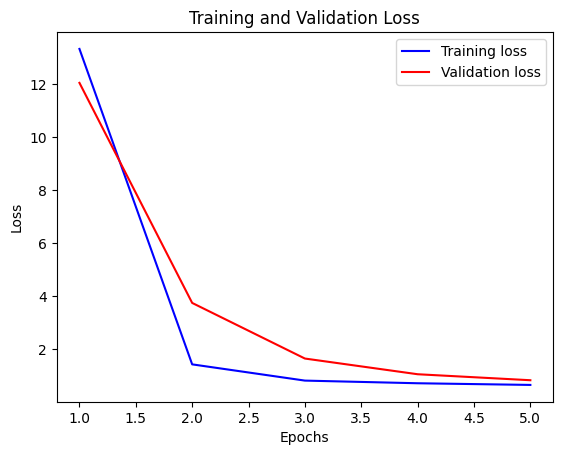

In [21]:
train_loss = results.history['loss']
val_loss = results.history['val_loss']

# Plot training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/resnet1shot-005.h5')

In [27]:
# Example: Predict on test data (replace with actual test data)
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Function to compute ROC curve
def compute_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

# Compute ROC curve
fpr, tpr, thresholds, roc_auc = compute_roc_curve(predictions, test_batch_labels)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions > optimal_threshold).astype(int)  # Note the '<' for distances

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

1/1 [==============================] - 3s 3s/step
Accuracy: 0.71875
Precision: 0.7692307692307693
Recall: 0.625
F1-Score: 0.6896551724137931
Optimal Threshold: 0.82808316
ROC AUC: 0.7421875


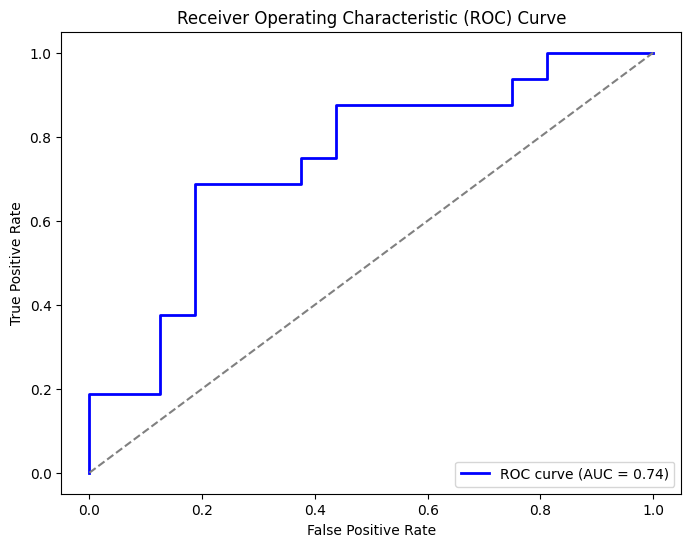

In [28]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 3s 3s/step


<ipython-input-29-f8cf05e75744>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


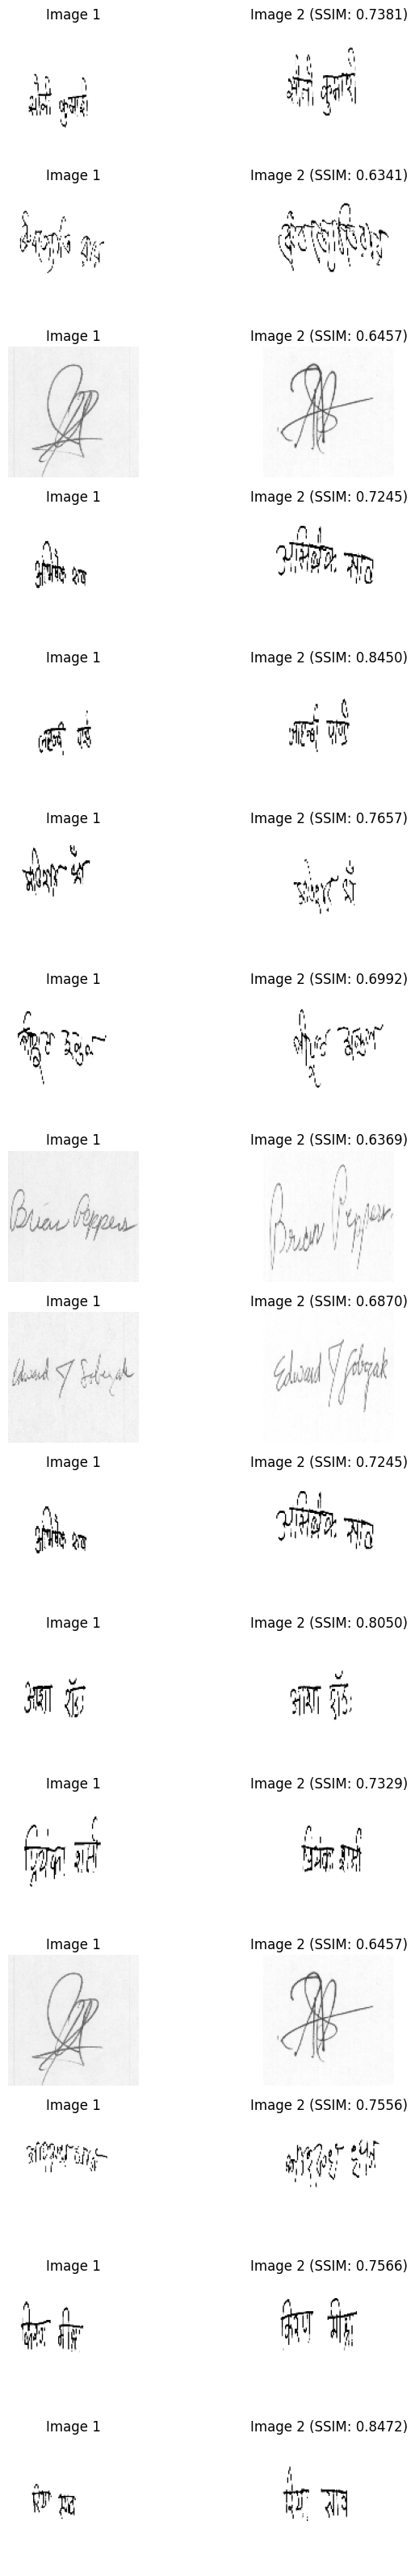

In [29]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))
    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    ssim_scores = []
    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)
        ssim_scores.append(ssim_score)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (SSIM: {ssim_score:.4f})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate average SSIM score
    average_ssim = np.mean(ssim_scores)
    print("Average SSIM score:", average_ssim)

# Call the function to display genuine-forged image pairs with SSIM scores and print the average SSIM score
display_genuine_forged_with_ssim(model, test_batch_generator)

Average SSIM score: 0.7277224822166687
1/1 [==============================] - 3s 3s/step


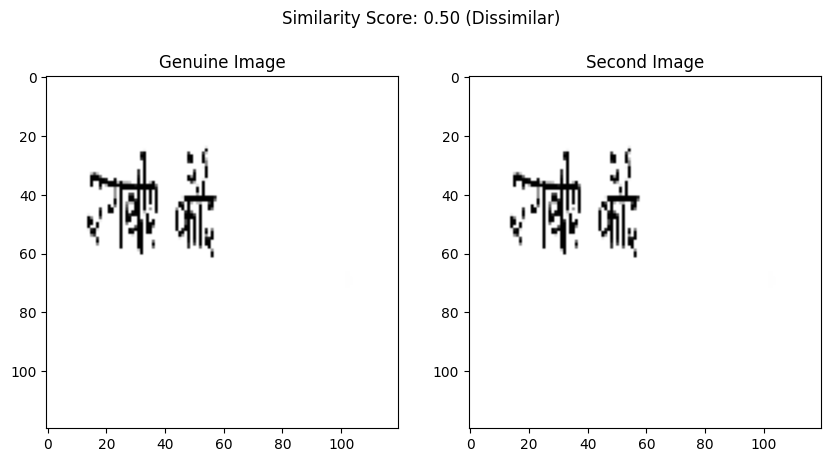

In [30]:
def show_similarity_score(model, orig_groups, forg_groups, img_h, img_w):
    # Select a random genuine image
    orig_idx = np.random.randint(len(orig_groups))
    orig = np.random.choice(orig_groups[orig_idx])

    # Select a random image (either genuine or forged)
    if np.random.randint(2) == 0:
        # Select a genuine image
        forg = np.random.choice(orig_groups[orig_idx])
        label = 1  # Set label to 1 for genuine pair
    else:
        # Select a forged image
        forg = np.random.choice(forg_groups[orig_idx])
        label = 0  # Set label to 0 for forged pair

    # Preprocess the images
    img1 = preprocess_image(orig)
    img2 = preprocess_image(forg)

    # Reshape the images for model input
    img1 = img1.reshape(1, img_h, img_w, 3)
    img2 = img2.reshape(1, img_h, img_w, 3)

    # Compute similarity score
    similarity_score = model.predict([img1, img2])[0][0]

    # Determine similarity or dissimilarity based on threshold
    threshold = optimal_threshold  # Adjust as needed
    if similarity_score >= threshold:
        similarity = "Similar"
    else:
        similarity = "Dissimilar"

    # Display the pair of images along with their similarity score
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1.squeeze())
    plt.title('Genuine Image')
    plt.subplot(1, 2, 2)
    plt.imshow(img2.squeeze())
    plt.title('Second Image')
    plt.suptitle('Similarity Score: {:.2f} ({})'.format(similarity_score, similarity))
    plt.show()

# Example usage
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 137ms/step


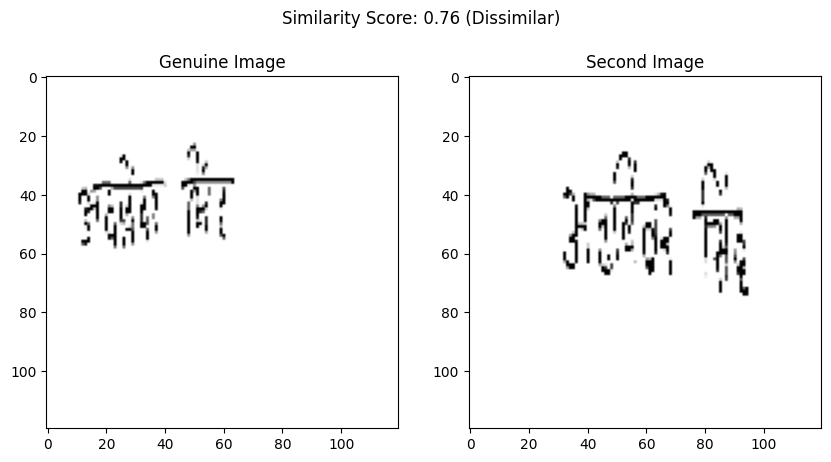

In [33]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 141ms/step


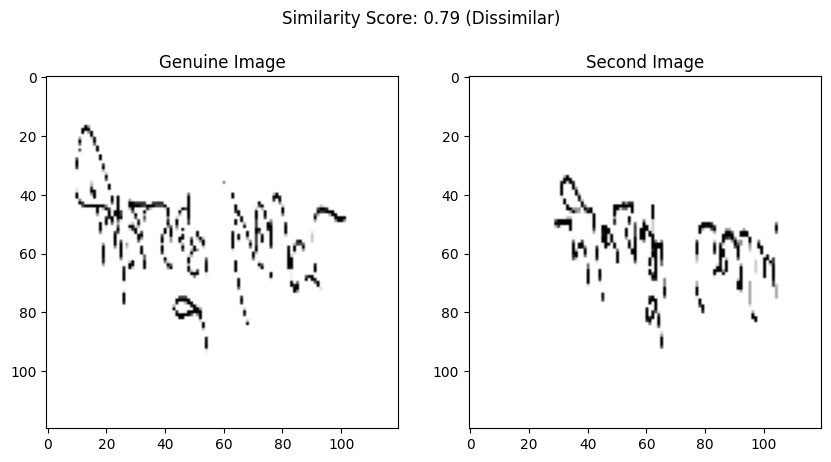

In [32]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 251ms/step


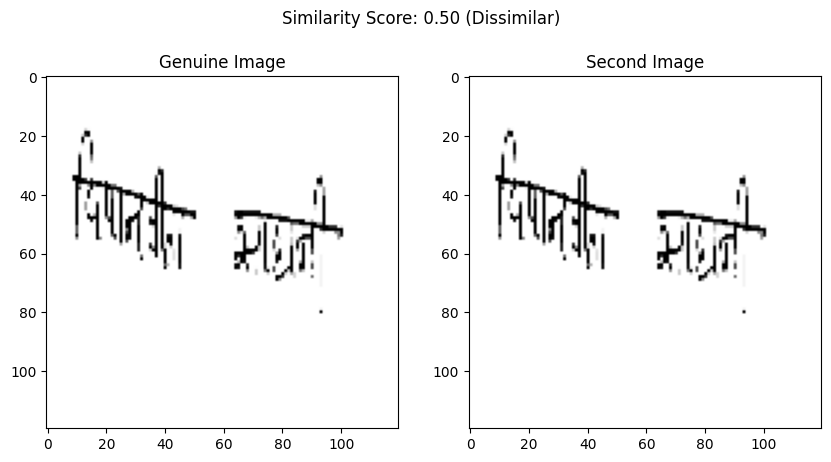

In [31]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 137ms/step


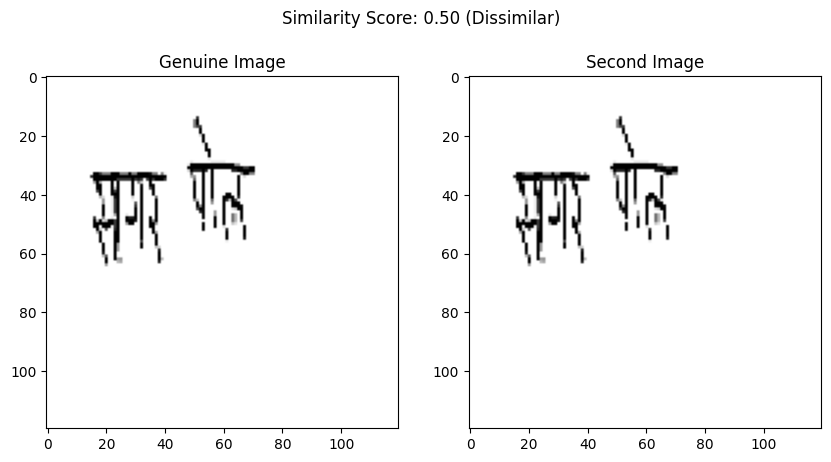

In [34]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 132ms/step


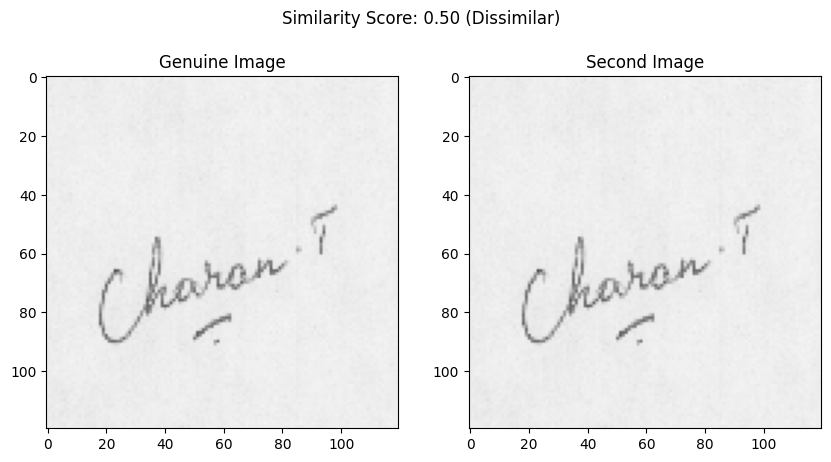

In [35]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 131ms/step


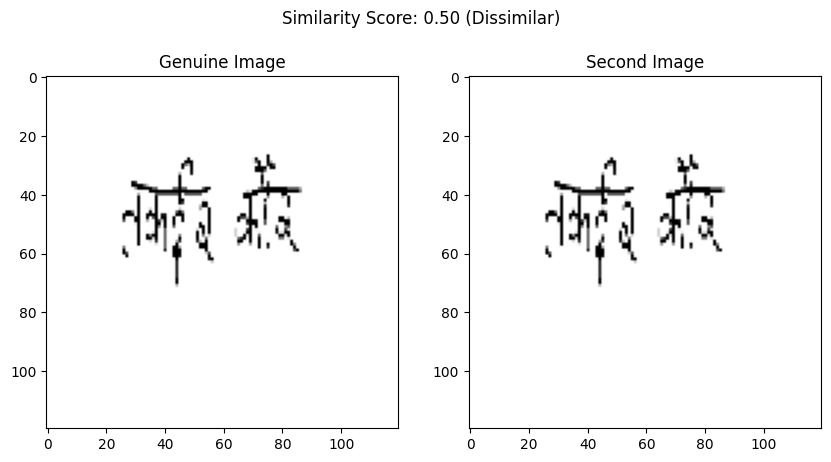

In [36]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 148ms/step


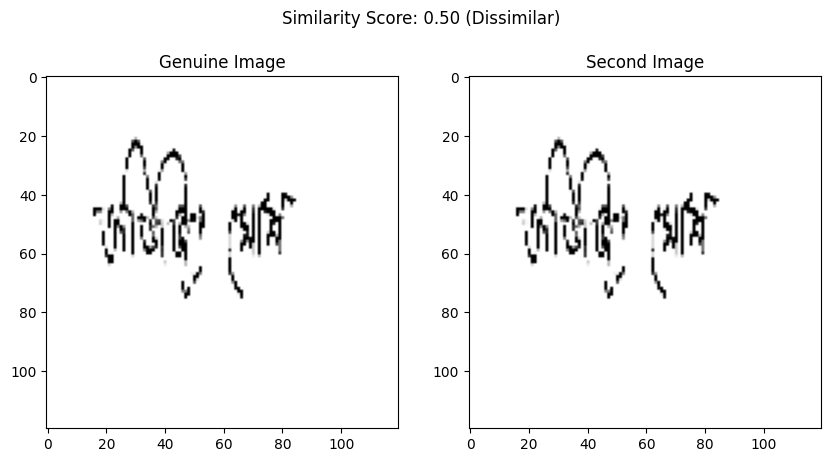

In [37]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 135ms/step


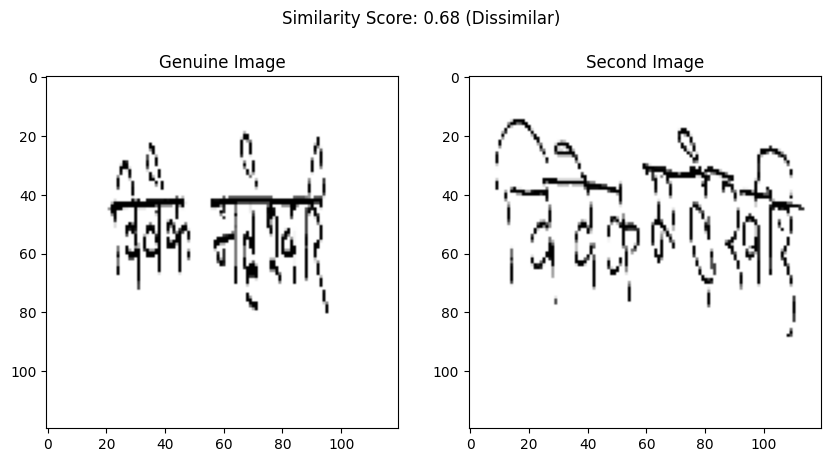

In [38]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 135ms/step


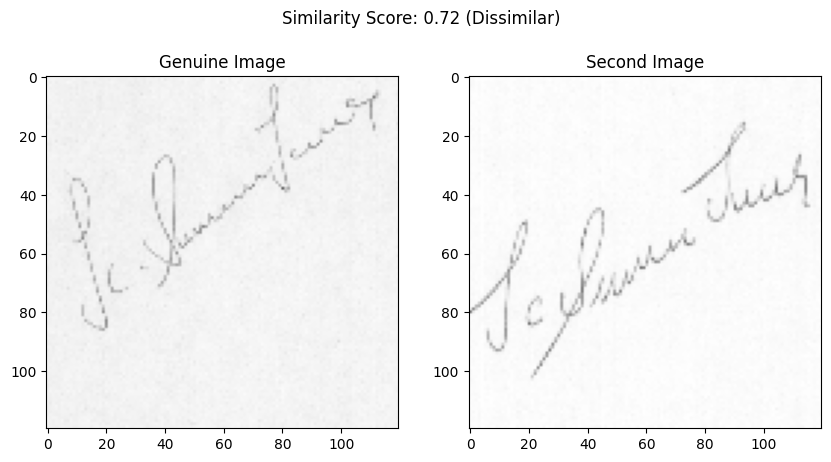

In [39]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 1s 633ms/step


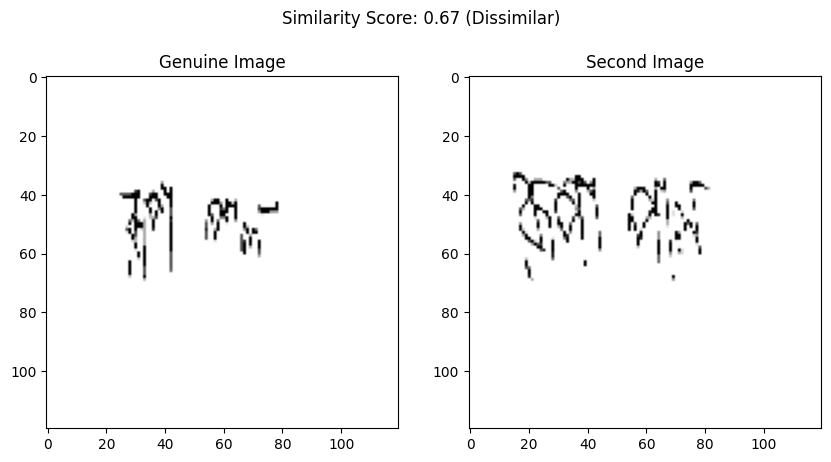

In [40]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 228ms/step


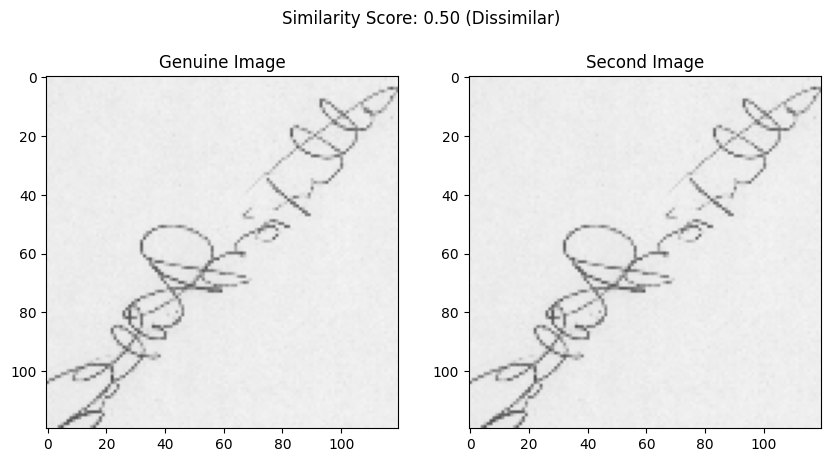

In [41]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 238ms/step


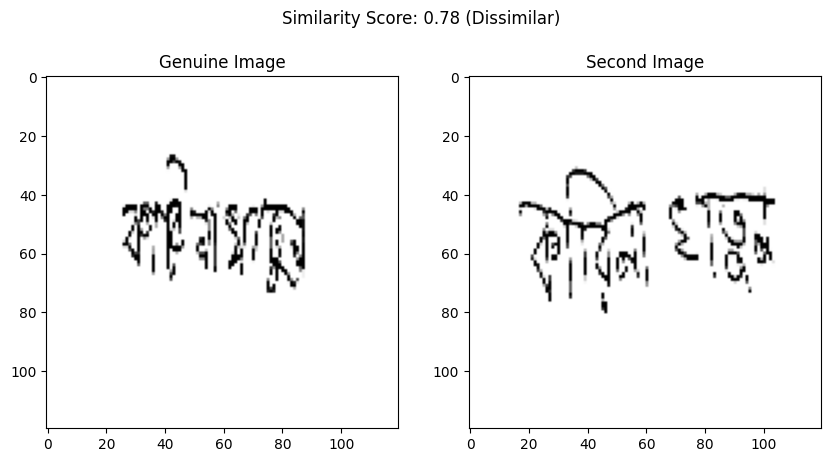

In [42]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 218ms/step


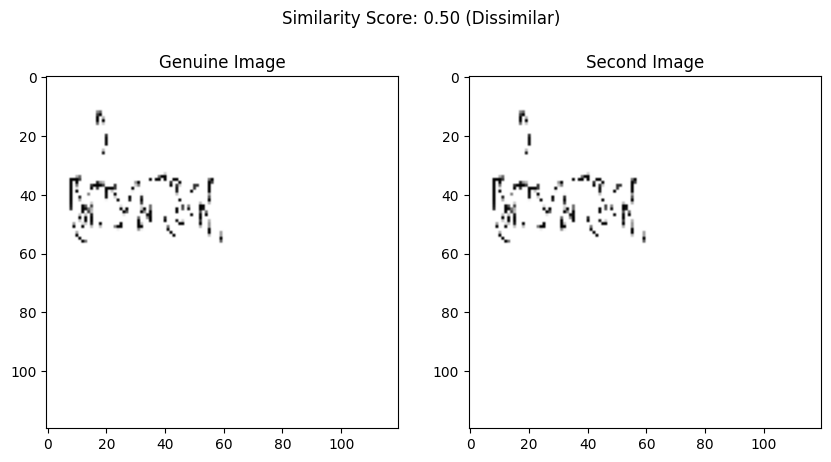

In [43]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 135ms/step


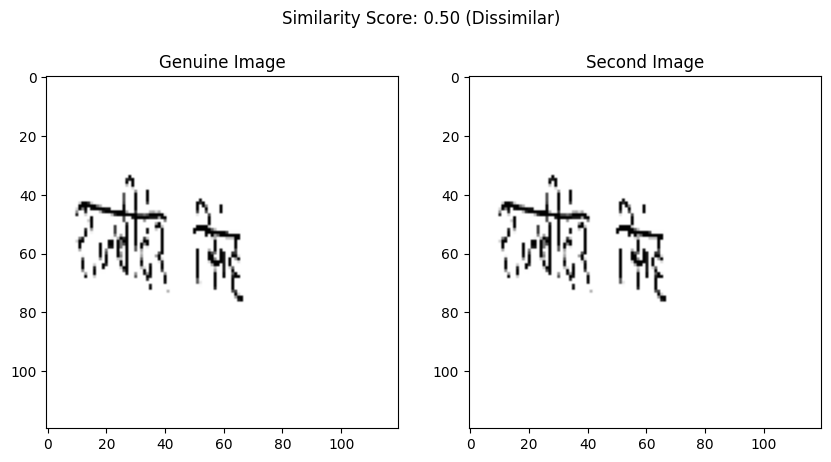

In [44]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 190ms/step


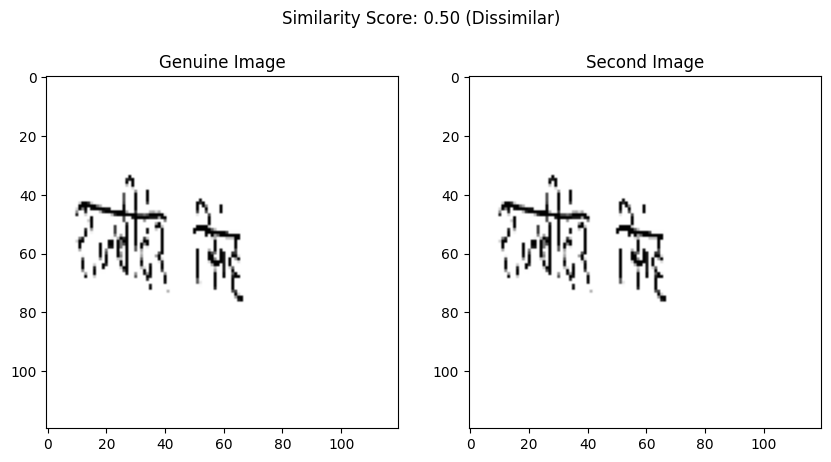

In [45]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 145ms/step


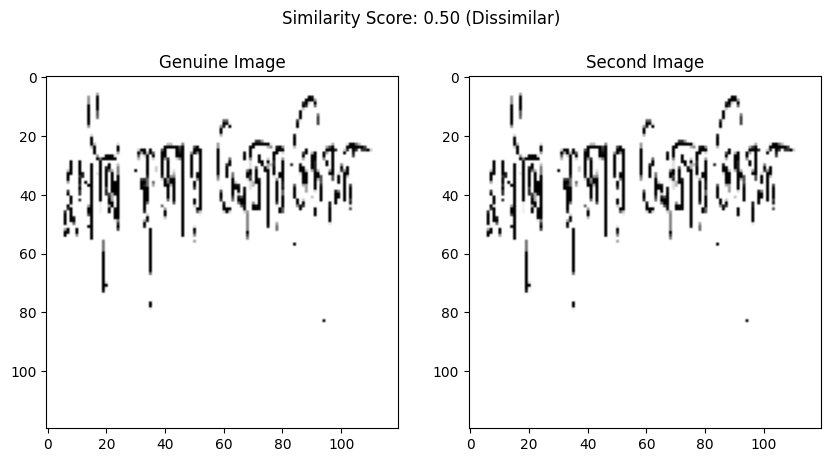

In [46]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 138ms/step


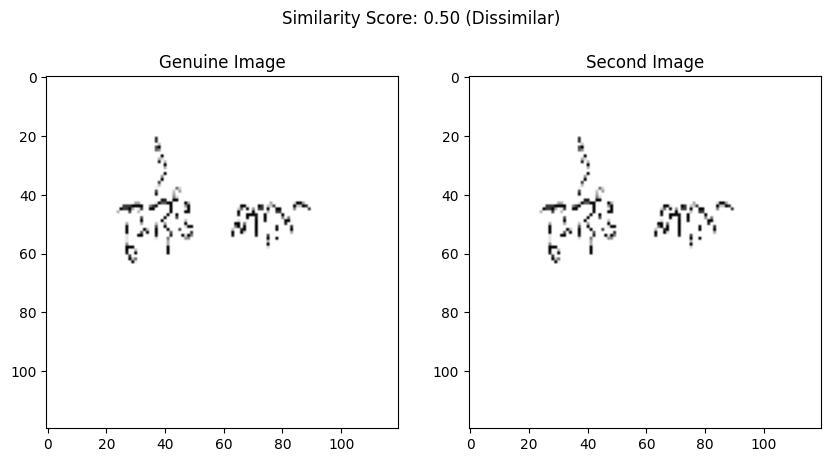

In [47]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 133ms/step


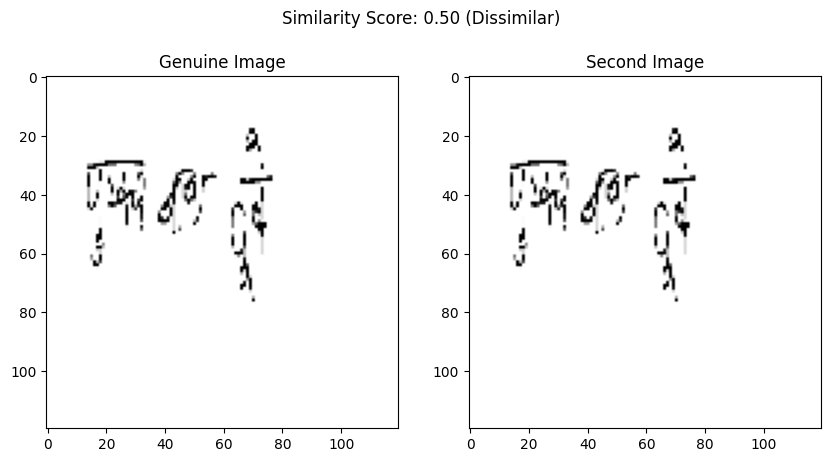

In [48]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 141ms/step


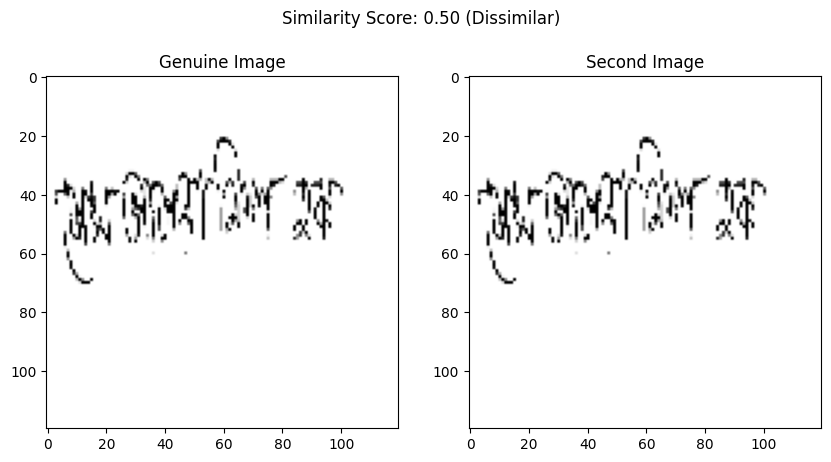

In [49]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

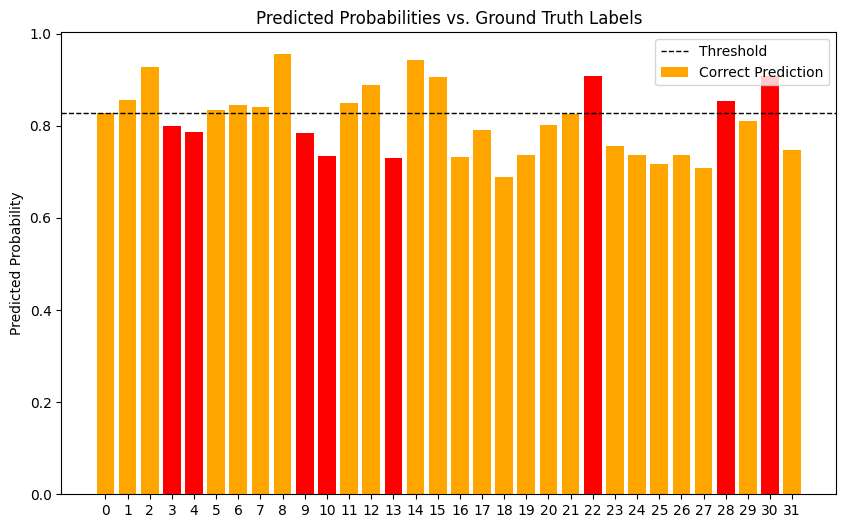

Predictions:
[[0.82808316]
 [0.8554033 ]
 [0.92720425]
 [0.8005527 ]
 [0.7870683 ]
 [0.8352832 ]
 [0.8452001 ]
 [0.8410575 ]
 [0.95521045]
 [0.7845048 ]
 [0.7346327 ]
 [0.84860516]
 [0.88826865]
 [0.7300911 ]
 [0.943548  ]
 [0.90689486]
 [0.7311972 ]
 [0.79104954]
 [0.68977636]
 [0.73577917]
 [0.8009904 ]
 [0.82485604]
 [0.9072171 ]
 [0.75561756]
 [0.73752624]
 [0.716401  ]
 [0.7375232 ]
 [0.7090069 ]
 [0.8533725 ]
 [0.8111192 ]
 [0.9072171 ]
 [0.74827164]]
Ground Truth Labels:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [50]:
# Convert predictions to binary values (0 or 1) using optimal_threshold
binary_predictions = np.where(predictions >= optimal_threshold, 1, 0)
# Define colors for correct and incorrect predictions
colors = ['orange' if pred == label else 'red' for pred, label in zip(binary_predictions, test_batch_labels)]
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(predictions)), predictions.flatten(), color=colors)
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs. Ground Truth Labels')
plt.xticks(range(len(predictions)))
plt.axhline(y=optimal_threshold, color='black', linestyle='--', linewidth=1)  # threshold line
# Add legend with correct and incorrect prediction labels
plt.legend(['Threshold', 'Correct Prediction', 'Incorrect Prediction'], loc='upper right')
plt.show()

# predictions, and labels
print("Predictions:")
print(predictions)
print("Ground Truth Labels:")
print(test_batch_labels)

In [ ]:
# Predict on test data
predictions = model.predict(test_batch_generator, steps=len(orig_test))

# Extract distances from predictions
distances = predictions.flatten()

# Print distances between pairs of images
for i, distance in enumerate(distances):
    pair_type = "Genuine" if i < len(distances) // 2 else "Forged"
    print(f"Pair {i+1}: Type: {pair_type}, Distance: {distance:.4f}")


18/32 [===============>..............] - ETA: 48s

In [ ]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)